In [1]:
#!/usr/bin/env python

In [2]:
"""Final Exam"""

'Final Exam'

In [3]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, cohen_kappa_score, confusion_matrix, roc_curve, roc_auc_score

In [4]:
warnings.filterwarnings('ignore')

# Exam Problem

A website sent advertisements by email to users who are interested in their product. Your task is to find a good model to predict if an advertisement will be clicked with given datasets.

In [5]:
user_data = pd.read_csv('user_features.csv')
prod_data = pd.read_csv('product_features.csv')
click_data = pd.read_csv('click_history.csv')

Let's begin by reading in all of our data using `read_csv` from the `pandas` library.

## Question 1: Data Understanding

Explore the basic information of the datasets. (10 points)

### User Data

We'll explore all of our dataframes one by one, starting with the user data.

In [6]:
user_data.head()

,user_id,number_of_clicks_before,ordered_before,personal_interests
0,104939,2,True,"['body', 'makeup', 'nail', 'hand', 'foot', 'me..."
1,101562,2,True,"['men_skincare', 'men_fragrance', 'tools', 'sk..."
2,102343,2,True,"['tools', 'makeup', 'foot', 'nail']"
3,106728,5,True,"['hand', 'men_skincare']"
4,107179,0,True,"['makeup', 'body', 'skincare', 'foot', 'men_sk..."


Calling the `head()` method gives us a preview of what the data looks like. We can observe  four columns of the data. `user_id` appears to be a column that uniquely identifies each user. `number_of_clicks_before` display the amount of times the users has clicked a product. `ordered_before` shows if the users has ever placed an order. If the user has placed at least one order, this field will be True, otherwise, is will be False. Finally, `personal_interests` shows the interest of each user. This column holds lists of one or more interests shown by the user.

In [7]:
print(user_data.shape)
print(user_data.dtypes)

(12000, 4)
user_id                     int64
number_of_clicks_before    object
ordered_before               bool
personal_interests         object
dtype: object


Digging a bit deeper into the features of the user data, we can see there are 12,000 rows of data. As we observed from our preview of the data, the data types of our columns include objects, integers, and boolean value. Upon first glance, we could have assumed `number_of_clicks_before` would be an `int64` columns as well. The data type of that column being `object` suggests that we should explore that column more. We can use a histogram to explore the unique values of this column, as well as their frequencies.

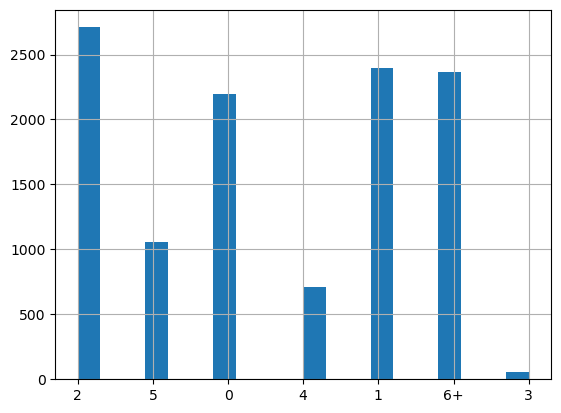

In [8]:
user_data.number_of_clicks_before.hist(bins=20)
plt.show()

Taking a look at our histogram, we see there are 7 unique values in the `number_of_clicks_before` column. We can see one of those values are '6+', which caused the data type of the column to be `object` rather than `int64`. We can also notice a small pattern in the frequencies of each value. For example, we can see the values 0, 1, and 2 all have frequencies greater than 2000. However, values 3, 4, and 5 all have frequencies below 1200, with 3 being significantly less frequent than 4 and 5. Since all clicks greater than 6 are grouped into one value, we may want to group the remaining values into bins later on.

Let's use the `personal_interest` column to see how popular each product category is. We must convert the string of personal interests in each row to a list. From there, we can create a dictionary to store the frequencies of each unique category that appears in the column.

In [9]:
unique_interests = {}
for row, x in enumerate(user_data.personal_interests):
  if x == '[]':
    pass
    user_data.personal_interests.loc[row] = []
  else:
    string = x.replace('[', '')
    string = string.replace(']', '');
    string = string.replace("'", '');
    new_lst = string.split(', ')
    user_data.personal_interests.loc[row] = new_lst
    x = new_lst
    for i in x:
      if i not in unique_interests.keys():
        unique_interests[i] = 1
      else:
        unique_interests[i] += 1

In [10]:
print(unique_interests)

{'body': 5442, 'makeup': 5418, 'nail': 5420, 'hand': 5353, 'foot': 5415, 'men_fragrance': 5356, 'fragrance': 5410, 'hair': 5397, 'tools': 5367, 'men_skincare': 5432, 'skincare': 5312}


As we can see from our dictionary, the frequencies of each interests are fairly equal to each other. The top three interests appear to be body, nail, and men fragrance.

In [11]:
user_data.ordered_before.value_counts()

True     8400
False    3600
Name: ordered_before, dtype: int64

The value counts of `ordered_before` lets us that 70% of all users in our data have placed an order before. Later on, we will be converting this column to dummy variable to prepare it for our classification.

In [12]:
user_data[user_data.drop('personal_interests', axis=1).duplicated()]

,user_id,number_of_clicks_before,ordered_before,personal_interests


In [13]:
user_data.personal_interests.dtype

dtype('O')

There are not any duplicates present in any of the columns of our data.

In [14]:
user_data.isnull().sum()

user_id                      0
number_of_clicks_before    500
ordered_before               0
personal_interests           0
dtype: int64

There appears to be 500 null values present in our `number_of_clicks_before` column. In the output below, we can see the specific columns where these values appear.

In [15]:
user_data[user_data.isnull().any(axis=1)]

,user_id,number_of_clicks_before,ordered_before,personal_interests
14,104407,NaN,True,"[hair, men_skincare]"
19,110542,NaN,True,"[tools, men_skincare, hair, makeup, foot, frag..."
47,107355,NaN,True,"[tools, skincare, men_fragrance, hand, fragran..."
70,104763,NaN,True,[nail]
95,100642,NaN,True,"[fragrance, men_fragrance, tools, body, nail, ..."
...,...,...,...,...
11879,111250,NaN,False,"[body, tools, skincare, men_skincare, hair, hand]"
11950,106529,NaN,True,"[foot, hair, body, nail]"
11957,105968,NaN,True,[]
11979,102180,NaN,True,"[nail, men_skincare, hand, foot]"


Later on, we will replace the null values in the `number_of_clicks_before` column with 0.

### Product Feature Data

Next, let's explore our product feature data!

In [16]:
prod_data.head()

,product_id,category,on_sale,number_of_reviews,avg_review_score
0,1134,tools,False,101,3.349452
1,1846,skincare,False,111,5.000000
2,1762,fragrance,False,220,4.882706
3,1254,hair,True,446,5.000000
4,1493,body,True,513,-1.000000


Looking at the preview of our product data, we see there are five columns of mixed data types. Similar to our user data, there is a unique id column named `product_id` to identify each unique product. The `category` column display the category of a specific product. It is worth noting that these categories are the same one present in the `personal_interest` column of our user data. The `on_sale` column indicates whether a product is on sale, True if it is and False otherwise. `number_of_reviews` and `avg_review_score` show how many reviews a product has and its average review score, respectively.

In [17]:
print(prod_data.shape)
print(prod_data.dtypes)

(1000, 5)
product_id             int64
category              object
on_sale                 bool
number_of_reviews      int64
avg_review_score     float64
dtype: object


It appears that there are 1000 products in our data. The data types for each of our columns are what we would expect.

In [18]:
prod_data.on_sale.value_counts()

True     650
False    350
Name: on_sale, dtype: int64

The value counts of the `on_sale` column indicates that 65% of all products are currently on sale.

In [19]:
prod_data.category.value_counts()

makeup           124
foot             120
hair             109
hand             102
men_skincare      98
body              97
skincare          76
men_fragrance     75
nail              72
fragrance         71
tools             56
Name: category, dtype: int64

The value counts of the `category` column lets us know how many products in each category are present. Most of the products fall under the makeup category, while the least amount of products fall under tools.

In [20]:
prod_data[['number_of_reviews', 'avg_review_score']].describe()

,number_of_reviews,avg_review_score
count,1.000000e+03,1000.000000
mean,1.157725e+05,2.660656
std,5.028997e+05,1.741875
min,6.600000e+01,-1.000000
25%,2.570000e+02,1.428969
50%,4.710000e+02,2.769397
75%,7.042500e+02,4.180860
max,2.307390e+06,5.000000


Next, lets use `describe()` to explore the numeric columns in our data.  For `number_of_reviews`, there are 1000 observations with a wide range, spanning from a minimum of 66 reviews to a maximum of over 2 million reviews.  The mean number of reviews is about 116,000, with a considerable standard deviation of around 502,899, indicating significant variability.  In contrast, `avg_review_score` exhibits a narrower range, with a mean score of approximately 2.66 and a standard deviation of around 1.74. The minimum value of -1 may require further investigation.

In [21]:
prod_data[prod_data.avg_review_score == -1]

,product_id,category,on_sale,number_of_reviews,avg_review_score
4,1493,body,True,513,-1.0
10,1827,makeup,True,528,-1.0
25,1411,hand,True,847,-1.0
69,1366,skincare,False,807,-1.0
95,1670,body,True,736,-1.0
...,...,...,...,...,...
893,1826,skincare,False,307,-1.0
903,1146,men_skincare,True,174,-1.0
956,1317,men_skincare,True,387,-1.0
978,1707,men_skincare,True,505,-1.0


In the output above, we can observe all rows that have an `avg_review_score` value of -1. There doesn't appear to be a specific pattern present amongst the other columns for these rows.

In [22]:
prod_data[prod_data.duplicated()].any()

product_id           False
category             False
on_sale              False
number_of_reviews    False
avg_review_score     False
dtype: bool

There are no duplicates present in any of our columns.

In [23]:
prod_data.isna().sum()

product_id           0
category             0
on_sale              0
number_of_reviews    0
avg_review_score     0
dtype: int64

There are no null values present in any of our columns.

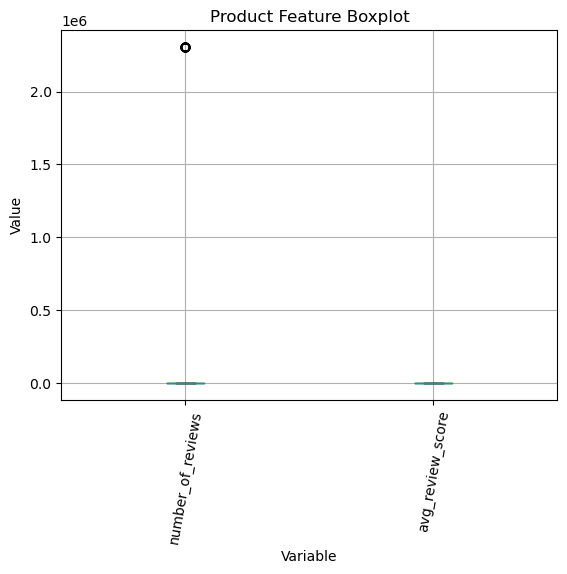

In [24]:
prod_data[['number_of_reviews', 'avg_review_score']].boxplot()
plt.title('Product Feature Boxplot')
plt.ylabel('Value')
plt.xlabel('Variable')
plt.xticks(rotation=80)
plt.show()

According to our boxplot, there is some outliers in the `number_of_reviews` column. We will remove this row later on.

### Click History Data

Finally, we will explore the click history data!

In [25]:
click_data.head()

,user_id,product_id,clicked
0,104863,1350,False
1,108656,1321,True
2,100120,1110,False
3,104838,1443,True
4,107304,1397,True


The click history data is very simple. Each row includes a `user_id` from the user data and a `product_id` from the product feature data. The `clicked` column tells us whether a particular user clicked a particular product.

In [26]:
print(click_data.shape)
print(click_data.dtypes)

(35990, 3)
user_id       int64
product_id    int64
clicked        bool
dtype: object


This data consists of nearly 36,000 rows. In the next section, we will convert our `clicked` column to dummy variables.

In [27]:
click_data.clicked.value_counts()

False    23302
True     12688
Name: clicked, dtype: int64

Based on the value counts of the `clicked` column, we see that most of the rows in the data show products that users have not clicked on.

In [28]:
click_data[click_data.duplicated()]

,user_id,product_id,clicked


There appears to be no duplicate rows in any of the data.

In [29]:
click_data.isna().sum()

user_id       0
product_id    0
clicked       0
dtype: int64

There are no null values in the data.

## Question 2: Data Cleaning and Preprocessing

Clean and preprocess the datasets (such as missing values, outliers, dummy, merging, etc.). (30 points)

The first step in cleaning our data is to remove any outliers. Based on our EDA, we found there is one outlier present in our product feature data.

In [30]:
def remove_outliers(data, column):
  """finds and resets outliers in a column"""
  q1 = np.quantile(data[column], .25)
  q3 = np.quantile(data[column], .75)
  iqr = q3 - q1
  print(data[(data[column] <= q1-(1.5*iqr)) | (data[column] >= q3+(1.5*iqr))])
  data = data.drop(data[(data[column] <= q1-(1.5*iqr)) | (data[column] >= q3+(1.5*iqr))].index)
  return data

In [31]:
remove_outliers(prod_data, 'number_of_reviews')

     product_id       category  on_sale  number_of_reviews  avg_review_score
8          1093         makeup     True            2307325          0.922366
17         1929           foot     True            2306891          0.960206
18         1885           hair     True            2306305          2.776561
40         1952       skincare    False            2307109          4.892617
63         1631   men_skincare     True            2306307          2.192205
75         1548           hair     True            2307117          2.416543
78         1463  men_fragrance    False            2307041          1.875636
91         1005       skincare    False            2306121          1.492753
147        1960           foot     True            2306809          3.728535
157        1459          tools    False            2306128          2.727487
162        1187           hand     True            2306178          3.850508
163        1542       skincare    False            2306318          1.572054

,product_id,category,on_sale,number_of_reviews,avg_review_score
0,1134,tools,False,101,3.349452
1,1846,skincare,False,111,5.000000
2,1762,fragrance,False,220,4.882706
3,1254,hair,True,446,5.000000
4,1493,body,True,513,-1.000000
...,...,...,...,...,...
995,1541,fragrance,False,312,1.149903
996,1326,body,True,603,1.277216
997,1062,foot,True,705,3.602008
998,1721,makeup,True,306,1.846254


50 rows identified as outliers have been removed.

Next, let's normalize and preprocess the `personal_interests` column so it can be used to train the model.

In [32]:
count_vect = CountVectorizer(stop_words='english')

In [33]:
text_data = pd.DataFrame()
for i in user_data.personal_interests:
  if i:
    data = count_vect.fit_transform(i)
    unique_words = count_vect.get_feature_names_out()
    freq = np.sum(data.toarray(), axis=0)
    freq = np.array(freq).reshape(1, (len(freq)))
    temp = pd.DataFrame(freq, columns=unique_words)
    text_data = pd.concat([text_data, temp], ignore_index=False)

In [34]:
text_data = text_data.add_prefix('user_interest_')

In [35]:
user_data = pd.merge(user_data, text_data, right_index=True, left_index=True)

We used `CountVectorizer` to get the frequency of all words in the personal interests of each user. Since all words in each list are unique, the result is simply a one hot encoding of each user's interests

In [36]:
user_data.drop('personal_interests', axis=1, inplace=True)

The `personal_interests` column is no longer needed so we will drop it.

In [37]:
user_data.fillna(0, inplace=True)

In [38]:
user_data.isnull().sum()

user_id                        0
number_of_clicks_before        0
ordered_before                 0
user_interest_body             0
user_interest_foot             0
user_interest_fragrance        0
user_interest_hair             0
user_interest_hand             0
user_interest_makeup           0
user_interest_men_fragrance    0
user_interest_nail             0
user_interest_tools            0
user_interest_men_skincare     0
user_interest_skincare         0
dtype: int64

Now, there are no more null values present! Next, we will convert all columns with boolean values to dummy variables. Since the dummy variables can only be True or False, we will change the values to 1 or 0 directly in the column.

In [39]:
user_data.loc[user_data['ordered_before'] == True, 'ordered_before'] = 1
user_data.loc[user_data['ordered_before'] == False, 'ordered_before'] = 0

In [40]:
prod_data.loc[prod_data['on_sale'] == True, 'on_sale'] = 1
prod_data.loc[prod_data['on_sale'] == False, 'on_sale'] = 0

In [41]:
click_data.loc[click_data['clicked'] == True, 'clicked'] = 1
click_data.loc[click_data['clicked'] == False, 'clicked'] = 0

As mentioned before, the data type of our `number_of_clicks_before` column will raise so issue for us during our model training. So, we will perform binning on the column.

In [42]:
user_data.loc[user_data['number_of_clicks_before'] == '6+', 'number_of_clicks_before'] = 7

Let's set all '6+' values present in the column to be 7. This is so that all values will be categorized correctly during binning.

In [43]:
user_data['number_of_clicks_before'] = user_data.number_of_clicks_before.astype('int')

we must also be sure that the data type of the column is `int`.

In [44]:
bins = [-np.inf, 0, 2, 4, 6, np.inf]

In [45]:
clicks = pd.cut(user_data.number_of_clicks_before, bins)
new_user_data = pd.merge(user_data.drop('number_of_clicks_before', axis=1), pd.get_dummies(clicks, dtype=int, prefix='user_prev_clicks'), left_index=True, right_index=True)

After preprocessing the user data, the results can be seen in the output below.

In [46]:
new_user_data

,user_id,ordered_before,user_interest_body,user_interest_foot,user_interest_fragrance,user_interest_hair,user_interest_hand,user_interest_makeup,user_interest_men_fragrance,user_interest_nail,user_interest_tools,user_interest_men_skincare,user_interest_skincare,"user_prev_clicks_(-inf, 0.0]","user_prev_clicks_(0.0, 2.0]","user_prev_clicks_(2.0, 4.0]","user_prev_clicks_(4.0, 6.0]","user_prev_clicks_(6.0, inf]"
0,104939,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0,1,0,0,0
0,104939,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0,1,0,0,0
0,104939,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0,1,0,0,0
0,104939,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0,1,0,0,0
0,104939,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,104939,1,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0,1,0,0,0
0,104939,1,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0,1,0,0,0
0,104939,1,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0,1,0,0,0
0,104939,1,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0,1,0,0,0


Next, we will generate dummies of the `category` column of the product data.

In [47]:
cat_dummies = pd.get_dummies(prod_data.category, dtype=int, prefix='category')
cat_dummies

,category_body,category_foot,category_fragrance,category_hair,category_hand,category_makeup,category_men_fragrance,category_men_skincare,category_nail,category_skincare,category_tools
0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1,0
2,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,1,0,0,0,0,0,0,0,0
996,1,0,0,0,0,0,0,0,0,0,0
997,0,1,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,1,0,0,0,0,0


I will use the indices of both the product data and the category dummies to join them both.

In [48]:
new_prod_data = pd.merge(prod_data, cat_dummies, left_index=True, right_index=True)
new_prod_data.drop('category', inplace=True, axis=1)

Finally, before we merge our data together, let's convert the `category` column of the prod_data to dummy variables. This final result of our preprocessing can be seen below.

In [49]:
master_data = pd.merge(click_data, user_data, on='user_id')
master_data = pd.merge(master_data, new_prod_data, on='product_id')
master_data = master_data.apply(pd.to_numeric)
master_data

,user_id,product_id,clicked,number_of_clicks_before,ordered_before,user_interest_body,user_interest_foot,user_interest_fragrance,user_interest_hair,user_interest_hand,...,category_foot,category_fragrance,category_hair,category_hand,category_makeup,category_men_fragrance,category_men_skincare,category_nail,category_skincare,category_tools
0,104939,1212,0,2,1,1.0,1.0,1.0,1.0,1.0,...,0,0,1,0,0,0,0,0,0,0
1,104939,1212,0,2,1,1.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
2,104939,1212,0,2,1,0.0,1.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
3,104939,1212,0,2,1,0.0,0.0,0.0,0.0,1.0,...,0,0,1,0,0,0,0,0,0,0
4,104939,1212,0,2,1,1.0,1.0,1.0,1.0,0.0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54515,104939,1195,1,2,1,0.0,1.0,1.0,1.0,1.0,...,0,0,0,1,0,0,0,0,0,0
54516,104939,1195,1,2,1,1.0,0.0,1.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
54517,104939,1195,1,2,1,1.0,0.0,0.0,1.0,1.0,...,0,0,0,1,0,0,0,0,0,0
54518,104939,1195,1,2,1,0.0,0.0,1.0,1.0,1.0,...,0,0,0,1,0,0,0,0,0,0


## Question 3: Model Generation and Evaluation

Please split the data into train and test sets with a ratio of 0.7:0.3. Build and optimize the classification models you learned in this course. (50 points)

We'll begin by seperating the response variable from the explanatory variables. Then, we will reserve 30% of the data to be used for testing.

In [50]:
X = master_data.drop('clicked', axis=1)
y = master_data.clicked

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

Let's train and evaluate 4 classification models. These models include `LogisticRegression`, `DecisionTreeClassifier`, `GaussianNB`, and `MLPClassifier`. We will first initialize the models, fit them using our training data, then predict labels for our testing data and measure the accuracy.

### Logistic Regression

In [52]:
lr = LogisticRegression()

In [53]:
lr.fit(X_train, y_train)

LogisticRegression()

In [54]:
lr_test_pred = lr.predict(X_test)
accuracy_score(y_test, lr_test_pred)

1.0

### Naive Bayes

In [55]:
nb = GaussianNB()

In [56]:
nb.fit(X_train, y_train)

GaussianNB()

In [57]:
nb_test_pred = nb.predict(X_test)
accuracy_score(y_test, nb_test_pred)

1.0

### Decision Tree

In [58]:
dt = DecisionTreeClassifier(max_depth=15, random_state=17)

In [59]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=15, random_state=17)

In [60]:
dt_test_pred = dt.predict(X_test)
accuracy_score(y_test, dt_test_pred)

1.0

### Neural Network

In [61]:
scaler = MinMaxScaler()

In [62]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [63]:
X_train_scaled[:3]
X_test_scaled[:3]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        0.        , 0.07082153, 0.88302632, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.09351145, 0.        , 0.        , 0.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        0.        , 0.96600567, 0.41022715, 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        1.        , 1.        , 1.        , 1.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
  

In [64]:
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 3), random_state=17)

In [65]:
nn.fit(X_train_scaled, y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(10, 3), random_state=17,
              solver='lbfgs')

In [66]:
nn_test_pred = nn.predict(X_test_scaled)
accuracy_score(y_test, nn_test_pred)

1.0

As we can see, all classifiers surprisingly predicted the labels for our testing data perfectly. All models returned a perfect accuracy score of 1.0 without any optimization needed.

## Question 4: Assessment and Evaluation

Which model has the best performance? What have you learned from the models you built? (10 points)

In [67]:
def model_eval(y_test, model_pred):
  """prints classification report, confusion matrix and Cohen's kappa score for input model"""
  print('Classification Report')
  print(classification_report(y_test, model_pred, target_names=['Not Clicked', 'Clicked']))
  
  print('\n')
  print('Confusion Matrix')
  print(pd.DataFrame(confusion_matrix(y_test, model_pred), index=['Not Clicked Act', 'Clicked Act'], columns=['Not Clicked Pred', 'Clicked Pred']))  
  print('\n')
  print('Cohen\'s kappa score:', round(cohen_kappa_score(y_test, model_pred), 4))

In [68]:
model_eval(y_test, lr_test_pred)

Classification Report
              precision    recall  f1-score   support

 Not Clicked       1.00      1.00      1.00     13048
     Clicked       1.00      1.00      1.00      3308

    accuracy                           1.00     16356
   macro avg       1.00      1.00      1.00     16356
weighted avg       1.00      1.00      1.00     16356



Confusion Matrix
                 Not Clicked Pred  Clicked Pred
Not Clicked Act             13048             0
Clicked Act                     0          3308


Cohen's kappa score: 1.0


In [69]:
model_eval(y_test, nb_test_pred)

Classification Report
              precision    recall  f1-score   support

 Not Clicked       1.00      1.00      1.00     13048
     Clicked       1.00      1.00      1.00      3308

    accuracy                           1.00     16356
   macro avg       1.00      1.00      1.00     16356
weighted avg       1.00      1.00      1.00     16356



Confusion Matrix
                 Not Clicked Pred  Clicked Pred
Not Clicked Act             13048             0
Clicked Act                     0          3308


Cohen's kappa score: 1.0


In [70]:
model_eval(y_test, dt_test_pred)

Classification Report
              precision    recall  f1-score   support

 Not Clicked       1.00      1.00      1.00     13048
     Clicked       1.00      1.00      1.00      3308

    accuracy                           1.00     16356
   macro avg       1.00      1.00      1.00     16356
weighted avg       1.00      1.00      1.00     16356



Confusion Matrix
                 Not Clicked Pred  Clicked Pred
Not Clicked Act             13048             0
Clicked Act                     0          3308


Cohen's kappa score: 1.0


In [71]:
model_eval(y_test, nn_test_pred)

Classification Report
              precision    recall  f1-score   support

 Not Clicked       1.00      1.00      1.00     13048
     Clicked       1.00      1.00      1.00      3308

    accuracy                           1.00     16356
   macro avg       1.00      1.00      1.00     16356
weighted avg       1.00      1.00      1.00     16356



Confusion Matrix
                 Not Clicked Pred  Clicked Pred
Not Clicked Act             13048             0
Clicked Act                     0          3308


Cohen's kappa score: 1.0


The outputs above display classification reports for each model, as well as confusion matrices and a cohen's kappa score. Just like the accuracy score, all metrics returned a perfect score of exactly 1. We can conclude that all models perform equally well compared to one another. It is worth noting, during our preprocessing of the data, it was unclear the benefit that `personal_interests` could serve for model training considering that it was one of the only text columns. Before converting `personal_interests` to dummies, I performed model training without the column present at all. The result of the models being trained on the data without the personal interests performed very poorly. Each model yielded an accuracy score around 65%. Once further preprocessing was applied to `personal_interests`, 11 features were added to the final data used for training. This step made a significant difference in the performance of the model. This leads us to believe a user's personal interests are amongst the most important features of the data. More generally, we see that increasing the number of relevant features in the data has the potential to increase model performance greatly. Overall, all of our models performed extremely well. Although the model was tested using never-before-seen data, the models would have to predict labels for an entire new dataset to rule out overfitting as a driver for the model's high performance.
